In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
from collections.abc import Iterable
from typing import Any

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, KFold, ParameterGrid, train_test_split
from sklearn.pipeline import FunctionTransformer, Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from tqdm import tqdm

from src import business, modeling, transforms, vis
from src.const import DATA_PATH, TARGET

# Для более качественных графиков
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 150
%load_ext autoreload
%autoreload 2

loan_data = pd.read_csv(DATA_PATH)

In [50]:
loan_data = pd.read_csv(DATA_PATH)
loan_data.head(2)

,лимит_нарушен,пол,тип,цель,кредитоспособность,другие_кредиты,бизнес,сумма,сбор,срок,...,один_платеж,стоимость_имущества,проживание,тип_залога,тип_кредита,кредитный_рейтинг,возраст,прямой_залог,дефолт,речь
0,0.0,м,3.0,0.0,1.0,NaN,0.0,174765.264968,normal,245.885949,...,0.0,244488.111841,осн,дом,2.0,709.508335,55-64,1.0,0,"""Hey there! I’m a guy with a solid job and a m..."
1,0.0,NaN,NaN,0.0,1.0,0.0,0.0,NaN,want,365.885949,...,0.0,NaN,осн,дом,1.0,722.508335,55-64,NaN,0,"""Hi there! We are a couple with a solid financ..."


In [51]:
loan_data.shape

(8000, 22)

In [52]:
loan_data.columns

Index(['лимит_нарушен', 'пол', 'тип', 'цель', 'кредитоспособность',
       'другие_кредиты', 'бизнес', 'сумма', 'сбор', 'срок', 'амортизация',
       'только_процент', 'один_платеж', 'стоимость_имущества', 'проживание',
       'тип_залога', 'тип_кредита', 'кредитный_рейтинг', 'возраст',
       'прямой_залог', 'дефолт', 'речь'],
      dtype='object')

In [53]:
print(loan_data["речь"][0])

"Hey there! I’m a guy with a solid job and a medium income. I've got plans in mind that require some funding, but my loan has been pre-approved. I’m confident I can manage the repayments without any stress. Let’s discuss the next steps forward!"


In [54]:
loan_data["речь"].isna().sum()

0

"Hey there! I’m a guy with a solid job and a medium income. I've got plans in mind that require some funding, but my loan has been pre-approved. I’m confident I can manage the repayments without any stress. Let’s discuss the next steps forward!"

In [55]:
who_defaulted =loan_data[loan_data["дефолт"] == 1]
who_defaulted.head(2)

,лимит_нарушен,пол,тип,цель,кредитоспособность,другие_кредиты,бизнес,сумма,сбор,срок,...,один_платеж,стоимость_имущества,проживание,тип_залога,тип_кредита,кредитный_рейтинг,возраст,прямой_залог,дефолт,речь
6,NaN,NaN,3.0,1.0,1.0,0.0,0.0,344765.264968,needfulness,137.885949,...,1.0,NaN,осн,дом,4.0,NaN,65-74,1.0,1,"""Hello! I prefer not to label myself, but my f..."
9,0.0,ж,2.0,1.0,1.0,0.0,1.0,NaN,requisite,185.885949,...,0.0,154488.111841,осн,дом,1.0,656.508335,35-44,1.0,1,"""Hi! I’m struggling a bit financially, and it ..."


In [56]:
who_defaulted.shape

(1894, 22)

In [57]:
((who_defaulted["стоимость_имущества"] - who_defaulted["сумма"] ) > 0).sum()

695

In [58]:
((who_defaulted["стоимость_имущества"] - who_defaulted["сумма"] ) > 0).sum() / len(who_defaulted)

0.366948257655755

In [59]:
preds = np.random.randint(0, 2, size=loan_data.shape[0])
preds

array([1, 0, 0, ..., 0, 0, 0])

In [60]:
loan_data[loan_data["дефолт"] == 1].describe().iloc[:2, :]

,лимит_нарушен,тип,цель,кредитоспособность,другие_кредиты,бизнес,сумма,срок,амортизация,только_процент,один_платеж,стоимость_имущества,тип_кредита,кредитный_рейтинг,прямой_залог,дефолт
count,1517.000000,1533.000000,1536.00000,1518.000000,1518.000000,1504.000000,1528.0000,1507.000000,1494.000000,1534.00000,1510.000000,883.000000,1514.00000,1504.000000,1512.000000,1894.0
mean,0.076467,2.585127,1.23763,0.951252,0.004611,0.197473,334595.1079,341.828219,0.180054,0.05867,0.059603,480127.975941,2.81638,708.762325,0.999339,1.0


In [61]:
loan_data[loan_data["дефолт"] == 0].describe().iloc[:2, :]

,лимит_нарушен,тип,цель,кредитоспособность,другие_кредиты,бизнес,сумма,срок,амортизация,только_процент,один_платеж,стоимость_имущества,тип_кредита,кредитный_рейтинг,прямой_залог,дефолт
count,4945.000000,4933.000000,4906.000000,4888.000000,4907.000000,4865.000000,4886.000000,4869.000000,4844.000000,4901.000000,4886.000000,4907.000000,4826.00000,4882.000000,4908.0,6106.0
mean,0.061881,2.688628,1.080717,0.964198,0.004687,0.115313,352771.814293,340.247009,0.077828,0.048562,0.007573,549187.520849,1.93908,710.786705,1.0,0.0


In [62]:
loan_data["один_платеж"].value_counts()

один_платеж
0.0    6269
1.0     127
Name: count, dtype: int64

In [63]:
loan_data.dtypes

лимит_нарушен          float64
пол                     object
тип                    float64
цель                   float64
кредитоспособность     float64
другие_кредиты         float64
бизнес                 float64
сумма                  float64
сбор                    object
срок                   float64
амортизация            float64
только_процент         float64
один_платеж            float64
стоимость_имущества    float64
проживание              object
тип_залога              object
тип_кредита            float64
кредитный_рейтинг      float64
возраст                 object
прямой_залог           float64
дефолт                   int64
речь                    object
dtype: object

In [64]:
loan_data["возраст"].value_counts()

возраст
45-54    1878
35-44    1777
55-64    1696
65-74    1137
25-34    1046
>74       376
<25        82
Name: count, dtype: int64

In [65]:
age_mapping = {
    "45-54": 3,     
    "35-44": 2,    
    "55-64": 4,     
    "65-74": 5,  
    "25-34": 1,    
    ">74": 6,       
    "<25": 0, 
}
loan_data["возраст"] = loan_data["возраст"].map(age_mapping)
loan_data["возраст"] = loan_data["возраст"].fillna(7)

In [66]:
loan_data["возраст"].value_counts()

возраст
3.0    1878
2.0    1777
4.0    1696
5.0    1137
1.0    1046
6.0     376
0.0      82
7.0       8
Name: count, dtype: int64

In [67]:
loan_data["возраст"].isna().sum()

0

In [68]:
loan_data.fillna("UNK").groupby(["пол", "дефолт"]).size() / len(loan_data)

пол  дефолт
UNK  0         0.408625
     1         0.119125
ж    0         0.136500
     1         0.044875
м    0         0.218125
     1         0.072750
dtype: float64

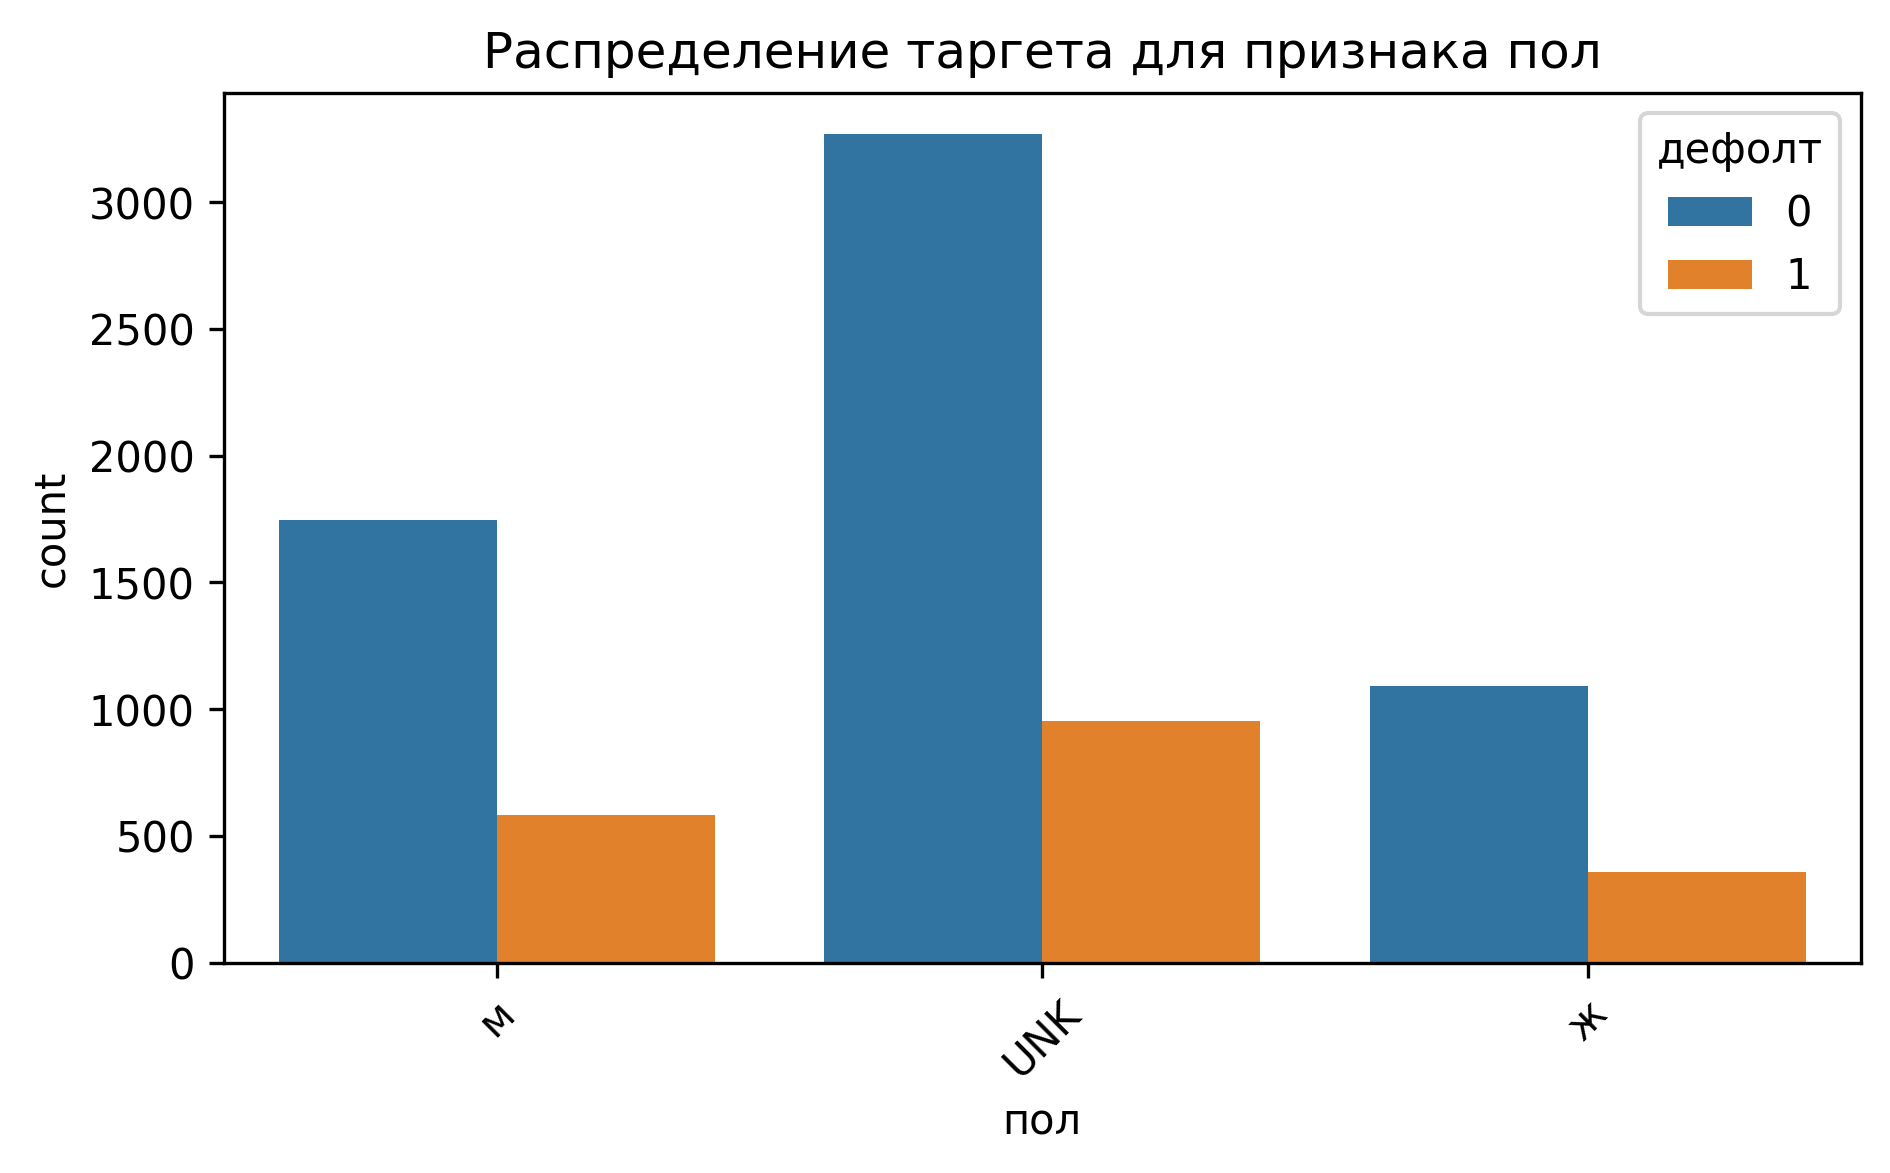

In [69]:
from src.vis import visualize_cat_and_target

visualize_cat_and_target(loan_data.fillna("UNK"), ["пол"])

In [70]:
loan_data["пол"].value_counts(dropna=False)

пол
NaN    4222
м      2327
ж      1451
Name: count, dtype: int64

In [71]:
gender_mapping = {
    "м": 1,     
    "ж": 2,     
}
loan_data["пол"] = loan_data["пол"].map(gender_mapping)
loan_data["пол"] = loan_data["пол"].fillna(0)

In [72]:
loan_data["пол"].value_counts(dropna=False)

пол
0.0    4222
1.0    2327
2.0    1451
Name: count, dtype: int64

In [73]:
loan_data["сбор"]

0                       normal
1                         want
2                      regular
3                       common
4                    excessive
                 ...          
7995                not slight
7996                      mean
7997       Whole lotta nothin'
7998    Total lack of presence
7999                 minuscule
Name: сбор, Length: 8000, dtype: object

In [ ]:
loan_data["сбор"].value_counts() # меньше < 5 = Rare

сбор
routine                109
common                 102
Nothing to be found     92
middle                  90
popular                 89
                      ... 
not copious              1
not wide                 1
half-pint                1
not incalculable         1
slight                   1
Name: count, Length: 410, dtype: int64

In [75]:
loan_data["проживание"].value_counts()

проживание
осн       7455
инвест     375
втор       170
Name: count, dtype: int64

In [ ]:
loan_data["тип_залога"].value_counts() # удалим

тип_залога
дом      7998
земля       2
Name: count, dtype: int64

In [ ]:
loan_data["речь"].value_counts() # посчитать кол-во символом

речь
"I'm a dedicated professional with a stable job, looking to manage my finances better. I believe in planning for the future and am eager to explore options that can help me achieve my goals. I appreciate your assistance in this journey."                                                                                      7
"Hello! I'm a dedicated professional with a stable job, and I'm here to discuss my financial needs. I believe in planning for the future and am looking for a loan to help me achieve my goals. I’m confident in my ability to repay it."                                                                                          4
"Hello! I'm a dedicated professional with a stable job, and I'm here to discuss my banking needs. I believe in planning for the future and am looking for ways to manage my finances effectively. I’m excited to explore options that can help me achieve my goals."                                                               4
"Hello! I'm a dedica

In [126]:
loan_data[["стоимость_имущества", "сумма"]].sum()

стоимость_имущества    3.118816e+09
сумма                  2.234904e+09
dtype: float64

# заменили кат

In [79]:
loan_data = pd.read_csv(DATA_PATH)

age_mapping = {
    "45-54": 3,     
    "35-44": 2,    
    "55-64": 4,     
    "65-74": 5,  
    "25-34": 1,    
    ">74": 6,       
    "<25": 0, 
}
loan_data["возраст"] = loan_data["возраст"].map(age_mapping)
loan_data["возраст"] = loan_data["возраст"].fillna(7)


gender_mapping = {
    "м": 1,     
    "ж": 2,     
}
loan_data["пол"] = loan_data["пол"].map(gender_mapping)
loan_data["пол"] = loan_data["пол"].fillna(0)

category_counts = loan_data["сбор"].value_counts()
rare_categories = category_counts[category_counts < 5].index
loan_data["сбор"] = loan_data["сбор"].replace(rare_categories, 'RARE')

mean_encoding = loan_data.groupby('сбор')['дефолт'].mean()
loan_data['сбор_mean_encoded'] = loan_data.pop('сбор').map(mean_encoding)

mean_encoding = loan_data.groupby('проживание')['дефолт'].mean()
loan_data['проживание_mean_encoded'] = loan_data.pop('проживание').map(mean_encoding)

loan_data.drop(columns=["тип_залога"], inplace=True)

loan_data["символов_в_речи"] = loan_data.pop("речь").str.len()

In [ ]:
loan_data.dtypes

лимит_нарушен              float64
пол                        float64
тип                        float64
цель                       float64
кредитоспособность         float64
другие_кредиты             float64
бизнес                     float64
сумма                      float64
срок                       float64
амортизация                float64
только_процент             float64
один_платеж                float64
стоимость_имущества        float64
тип_кредита                float64
кредитный_рейтинг          float64
возраст                    float64
прямой_залог               float64
дефолт                       int64
сбор_mean_encoded          float64
проживание_mean_encoded    float64
символов_в_речи              int64
dtype: object

In [81]:
loan_data.isna().sum()

лимит_нарушен              1538
пол                           0
тип                        1534
цель                       1558
кредитоспособность         1594
другие_кредиты             1575
бизнес                     1631
сумма                      1586
срок                       1624
амортизация                1662
только_процент             1565
один_платеж                1604
стоимость_имущества        2210
тип_кредита                1660
кредитный_рейтинг          1614
возраст                       0
прямой_залог               1580
дефолт                        0
сбор_mean_encoded             0
проживание_mean_encoded       0
символов_в_речи               0
dtype: int64

In [82]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
imputed = imputer.fit_transform(loan_data)

loan_data = pd.DataFrame(imputed, columns=loan_data.columns)

In [83]:
loan_data.isna().sum()

лимит_нарушен              0
пол                        0
тип                        0
цель                       0
кредитоспособность         0
другие_кредиты             0
бизнес                     0
сумма                      0
срок                       0
амортизация                0
только_процент             0
один_платеж                0
стоимость_имущества        0
тип_кредита                0
кредитный_рейтинг          0
возраст                    0
прямой_залог               0
дефолт                     0
сбор_mean_encoded          0
проживание_mean_encoded    0
символов_в_речи            0
dtype: int64

In [84]:
loan_data

,лимит_нарушен,пол,тип,цель,кредитоспособность,другие_кредиты,бизнес,сумма,срок,амортизация,...,один_платеж,стоимость_имущества,тип_кредита,кредитный_рейтинг,возраст,прямой_залог,дефолт,сбор_mean_encoded,проживание_mean_encoded,символов_в_речи
0,0.0,1.0,3.0,0.0,1.0,0.0,0.0,174765.264968,245.885949,0.0,...,0.0,244488.111841,2.0,709.508335,4.0,1.0,0.0,0.000000,0.234205,245.0
1,0.0,0.0,3.0,0.0,1.0,0.0,0.0,314765.264968,365.885949,0.0,...,0.0,454488.111841,1.0,722.508335,4.0,1.0,0.0,0.654545,0.234205,283.0
2,0.0,1.0,3.0,1.0,1.0,0.0,0.0,314765.264968,365.885949,0.0,...,0.0,364488.111841,1.0,785.508335,4.0,1.0,0.0,0.000000,0.234205,269.0
3,0.0,0.0,3.0,1.0,1.0,0.0,0.0,474765.264968,365.885949,0.0,...,0.0,894488.111841,2.0,594.508335,2.0,1.0,0.0,0.000000,0.234205,211.0
4,0.0,0.0,3.0,1.0,1.0,0.0,0.0,384765.264968,365.885949,0.0,...,0.0,504488.111841,2.0,589.508335,4.0,1.0,0.0,0.000000,0.234205,258.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.0,0.0,3.0,1.0,1.0,0.0,0.0,314765.264968,125.885949,0.0,...,0.0,744488.111841,2.0,708.508335,2.0,1.0,0.0,0.000000,0.234205,232.0
7996,0.0,0.0,3.0,1.0,1.0,0.0,1.0,314765.264968,185.885949,0.0,...,0.0,184488.111841,1.0,796.508335,6.0,1.0,0.0,0.000000,0.234205,245.0
7997,0.0,1.0,3.0,3.0,1.0,0.0,0.0,394765.264968,365.885949,0.0,...,0.0,454488.111841,4.0,584.508335,1.0,1.0,1.0,0.596491,0.234205,250.0
7998,0.0,0.0,3.0,1.0,1.0,0.0,0.0,594765.264968,365.885949,0.0,...,0.0,454488.111841,2.0,873.508335,2.0,1.0,0.0,0.446809,0.234205,273.0


# сплит

In [127]:
loan_data = pd.read_csv(DATA_PATH)

df_train, df_test = train_test_split(
    loan_data,
    test_size=0.2,       
    random_state=42,     
)
df_train_original = df_train.copy()
df_test_original = df_test.copy()

df_train["возраст"] = df_train["возраст"].map(age_mapping).fillna(7) 
df_test["возраст"] = df_test["возраст"].map(age_mapping).fillna(7) 

df_train["пол"] = df_train["пол"].map(gender_mapping).fillna(0) 
df_test["пол"] = df_test["пол"].map(gender_mapping).fillna(0) 

category_counts = df_train["сбор"].value_counts()
rare_categories = category_counts[category_counts < 5].index

df_train["сбор"] = df_train["сбор"].replace(rare_categories, 'RARE')
df_test["сбор"] = df_test["сбор"].replace(rare_categories, 'RARE')

sbor_mean_encoding = df_train.groupby('сбор')['дефолт'].mean()
df_train['сбор_mean_encoded'] = df_train.pop('сбор').map(sbor_mean_encoding)
df_test['сбор_mean_encoded'] = df_test.pop('сбор').map(sbor_mean_encoding)

liv_mean_encoding = df_train.groupby('проживание')['дефолт'].mean()
df_train['проживание_mean_encoded'] = df_train.pop('проживание').map(liv_mean_encoding)
df_test['проживание_mean_encoded'] = df_test.pop('проживание').map(liv_mean_encoding)

df_train.drop(columns=["тип_залога"], inplace=True)
df_test.drop(columns=["тип_залога"], inplace=True)

df_train["символов_в_речи"] = df_train.pop("речь").str.len()
df_test["символов_в_речи"] = df_test.pop("речь").str.len()

imputer = SimpleImputer(strategy='median')
imputer = imputer.fit(df_train)

df_train = pd.DataFrame(imputer.transform(df_train), columns=df_train.columns)
df_test = pd.DataFrame(imputer.transform(df_test), columns=df_test.columns)


In [128]:
df_train

,лимит_нарушен,пол,тип,цель,кредитоспособность,другие_кредиты,бизнес,сумма,срок,амортизация,...,один_платеж,стоимость_имущества,тип_кредита,кредитный_рейтинг,возраст,прямой_залог,дефолт,сбор_mean_encoded,проживание_mean_encoded,символов_в_речи
0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,304765.264968,365.885949,0.0,...,0.0,3.744881e+05,2.0,799.508335,3.0,1.0,0.0,0.000000,0.231492,232.0
1,1.0,0.0,1.0,3.0,1.0,0.0,0.0,314765.264968,365.885949,0.0,...,0.0,9.444881e+05,3.0,672.508335,1.0,1.0,0.0,0.619048,0.231492,244.0
2,0.0,0.0,3.0,0.0,1.0,0.0,0.0,744765.264968,245.885949,0.0,...,0.0,1.294488e+06,2.0,708.508335,3.0,1.0,0.0,0.000000,0.231492,278.0
3,0.0,1.0,2.0,3.0,1.0,0.0,0.0,284765.264968,365.885949,0.0,...,0.0,4.544881e+05,4.0,708.508335,0.0,1.0,1.0,0.641026,0.231492,266.0
4,0.0,0.0,2.0,3.0,1.0,0.0,1.0,204765.264968,365.885949,1.0,...,0.0,4.544881e+05,4.0,713.508335,5.0,1.0,1.0,0.547619,0.231492,214.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6395,0.0,0.0,3.0,1.0,1.0,0.0,0.0,314765.264968,365.885949,0.0,...,0.0,9.444881e+05,3.0,708.508335,5.0,1.0,0.0,0.000000,0.231492,252.0
6396,0.0,0.0,3.0,0.0,1.0,0.0,0.0,424765.264968,329.885949,0.0,...,0.0,4.544881e+05,1.0,824.508335,5.0,1.0,0.0,0.641026,0.231492,293.0
6397,0.0,0.0,2.0,1.0,1.0,0.0,1.0,234765.264968,365.885949,1.0,...,0.0,2.844881e+05,1.0,862.508335,3.0,1.0,0.0,0.000000,0.231492,230.0
6398,0.0,0.0,3.0,3.0,1.0,0.0,0.0,164765.264968,365.885949,1.0,...,0.0,2.244881e+05,2.0,708.508335,2.0,1.0,0.0,0.000000,0.231492,248.0


In [129]:
X_train = df_train.drop(columns=[TARGET])
y_train = df_train[TARGET].astype(int)

X_test = df_test.drop(columns=[TARGET])
y_test = df_test[TARGET].astype(int)

In [130]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [131]:
y_pred = clf.predict(X_train)
np.bincount(y_pred)
clf.score(X_train, y_train) * 100

88.34375

In [132]:
clf.score(X_test, y_test) * 100

87.625

In [133]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_pred)

array([[4401,  506],
       [ 240, 1253]], dtype=int64)

In [134]:
confusion_matrix(y_test, clf.predict(X_test))

array([[1074,  125],
       [  73,  328]], dtype=int64)

In [135]:
# x_pred_test = clf.predict(X_test)
# np.bincount(x_pred_test)

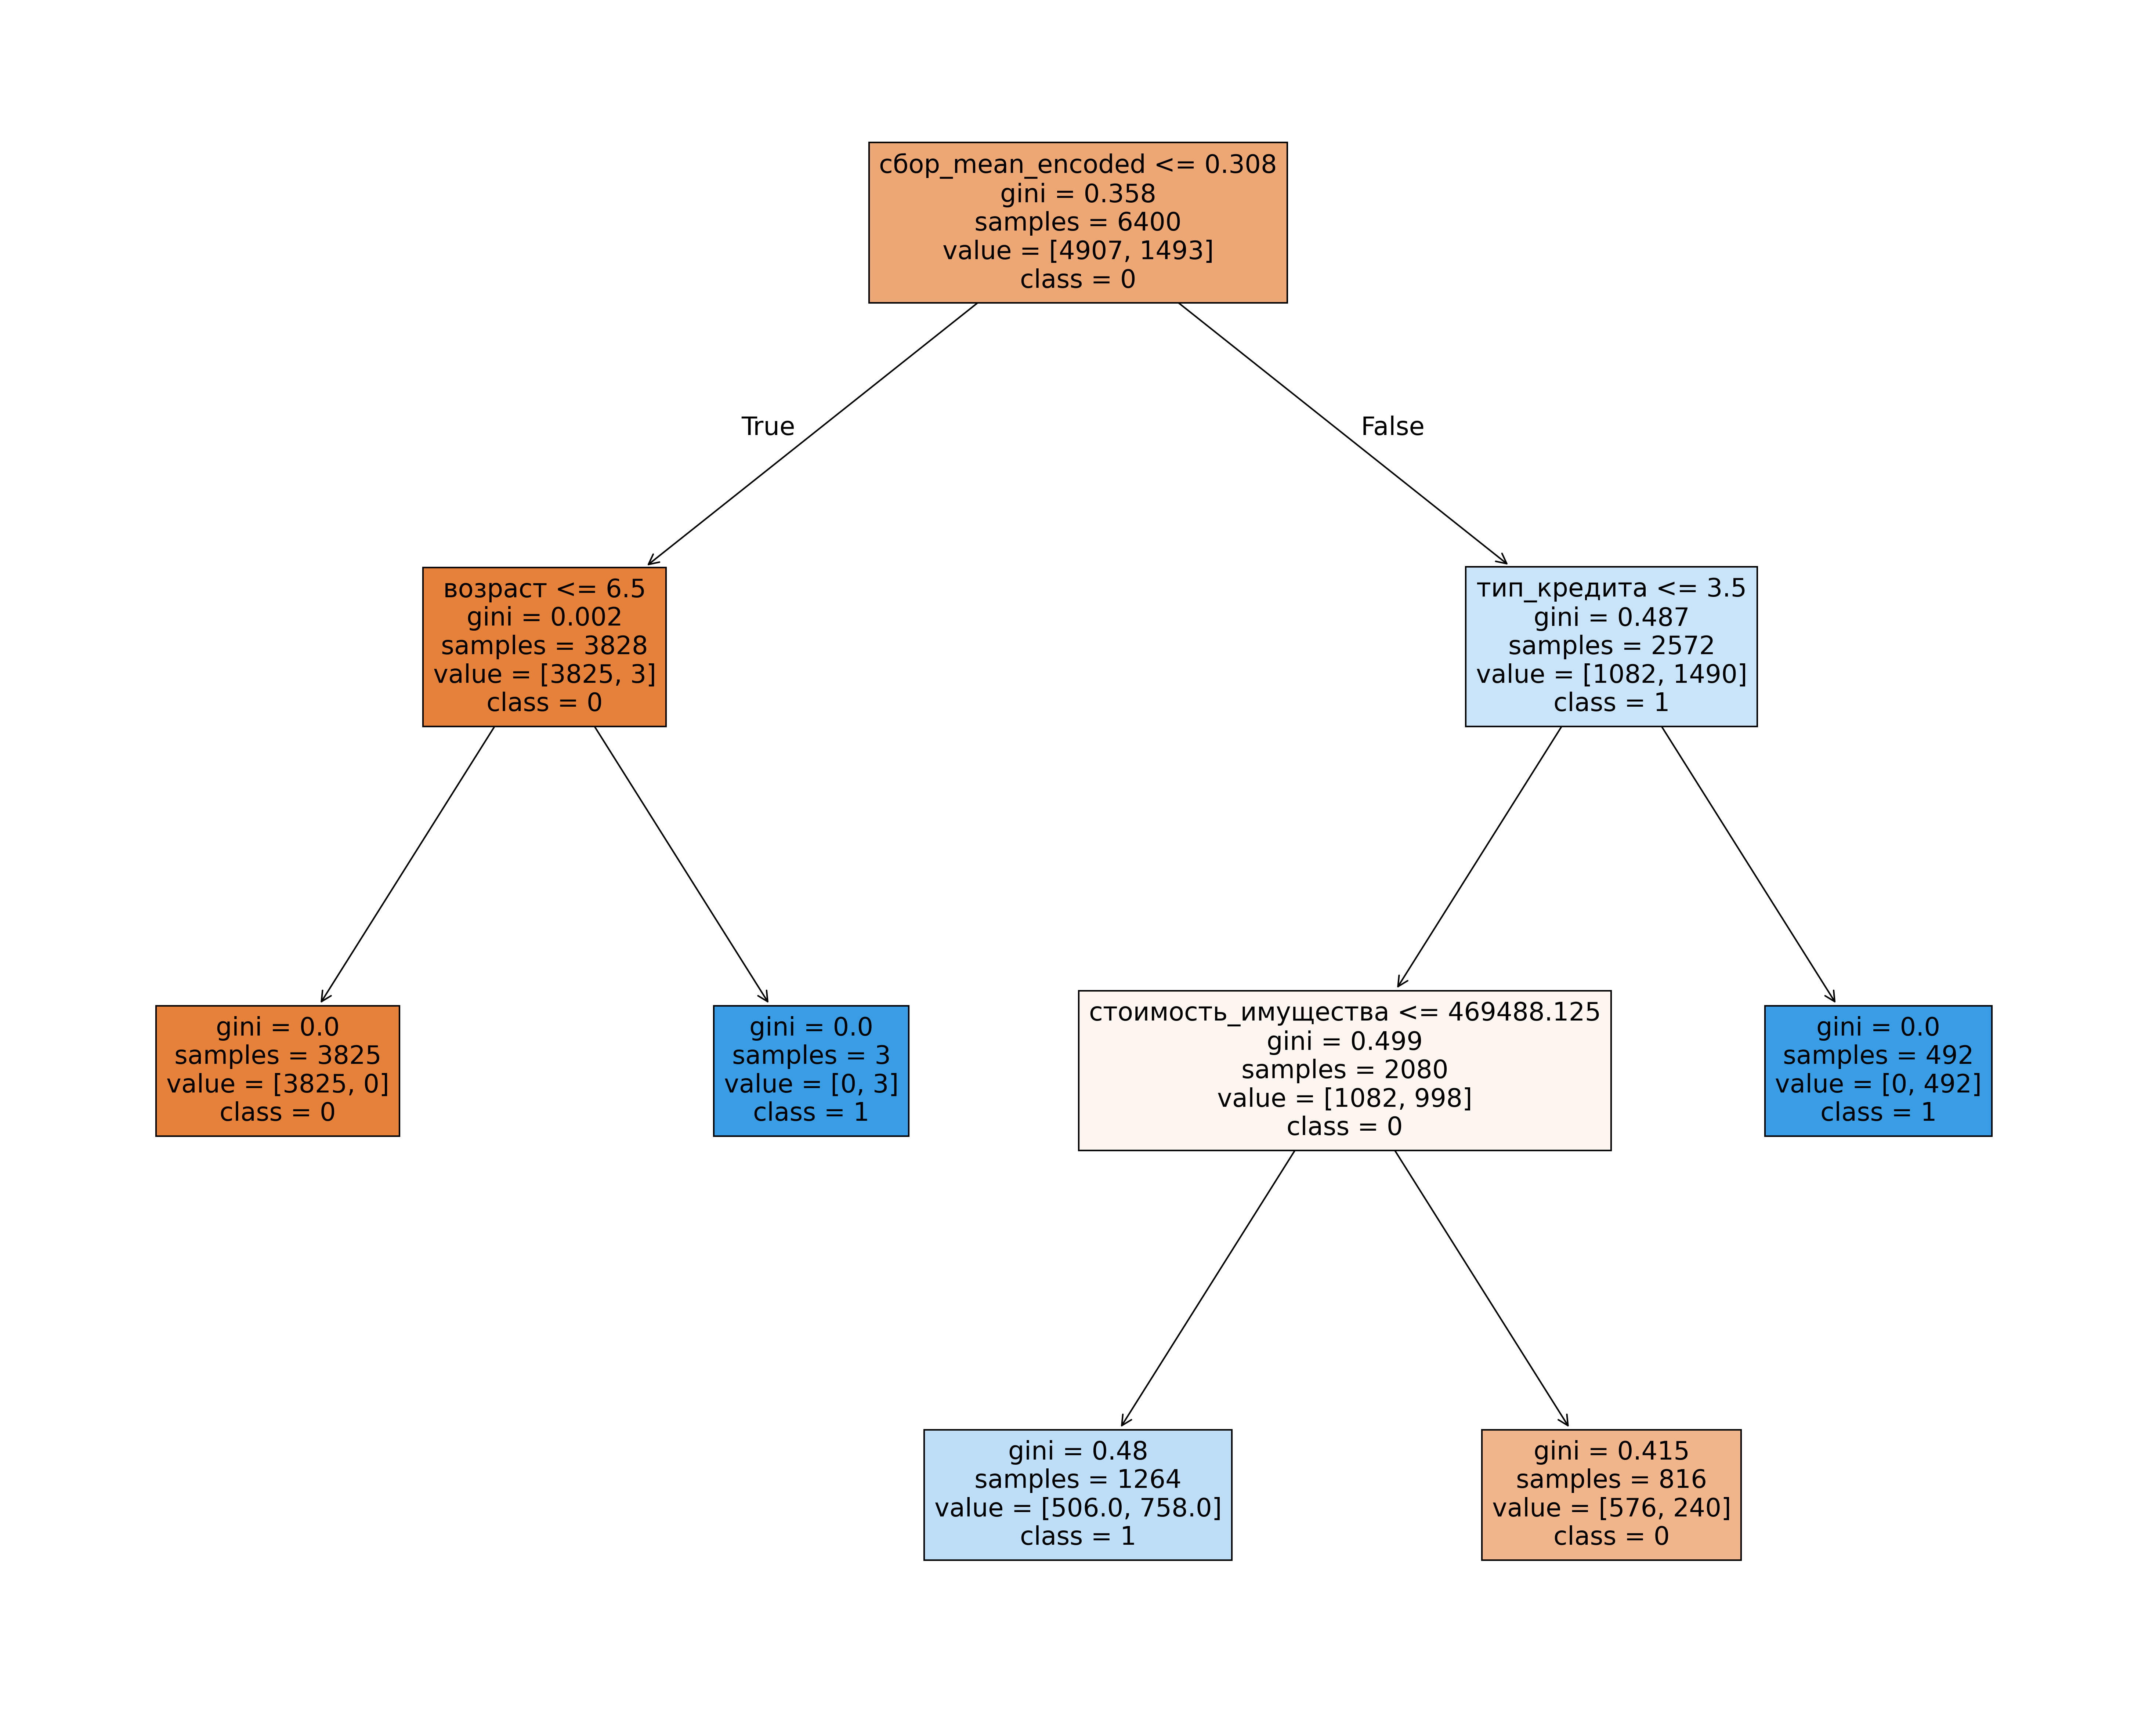

In [136]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25,20))
_ = plot_tree(clf,
                   feature_names=X_train.columns,
                   class_names=["0", "1"],
                   filled=True)

In [137]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=3)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3)

In [138]:
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.8484375, 0.835625)

In [178]:
def our_profit(loan_amount, y_pred, y_true):
    return np.where(
        (y_true == 1) & (y_pred == 0),
        -loan_amount * 0.5,
        np.where(
            (y_true == 0) & (y_pred == 0),
            loan_amount * 0.1,
            0
        )
    ).mean()

In [179]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print("Бизнес-метрика на трейне", our_profit(df_train["сумма"], y_pred_train, y_train))
print("Бизнес-метрика на тесте", our_profit(df_test["сумма"], y_pred_test, y_test))
print("Точность на трейне:", clf.score(X_train, y_train))
print("Точность на тесте:", clf.score(X_test, y_test))

Бизнес-метрика на трейне 26426.45554996667
Бизнес-метрика на тесте 11782.36382093263
Точность на трейне: 1.0
Точность на тесте: 0.8925


In [ ]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

In [189]:
clf = RandomForestClassifier()
grid_search = GridSearchCV(
    estimator=clf,
    param_grid={"n_estimators": np.arange(3, 101), "max_depth": np.arange(2, 11)},
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=3
)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 882 candidates, totalling 2646 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'n_estimators': array([  3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100])},
             scoring='accuracy', verbose=3)

In [190]:
grid_search.best_params_

{'max_depth': 10, 'n_estimators': 95}

In [192]:
clf = RandomForestClassifier(**grid_search.best_params_)
clf.fit(X_train, y_train)

y_pred_train = clf.predict_proba(X_train)
y_pred_test = clf.predict_proba(X_test)

pts = []

for t in np.linspace(0, 1, 100):
    y_pred_train_t = (y_pred_train[:, 1] > t).astype(int)
    y_pred_test_t = (y_pred_test[:, 1] > t).astype(int)

    profit_train_t = our_profit(df_train["сумма"], y_pred_train_t, y_train)
    profit_test_t = our_profit(df_test["сумма"], y_pred_test_t, y_test)

    pts.append((t, profit_train_t, profit_test_t))
stats_t = pd.DataFrame(pts, columns=["t", "profit@train", "profit@test"])

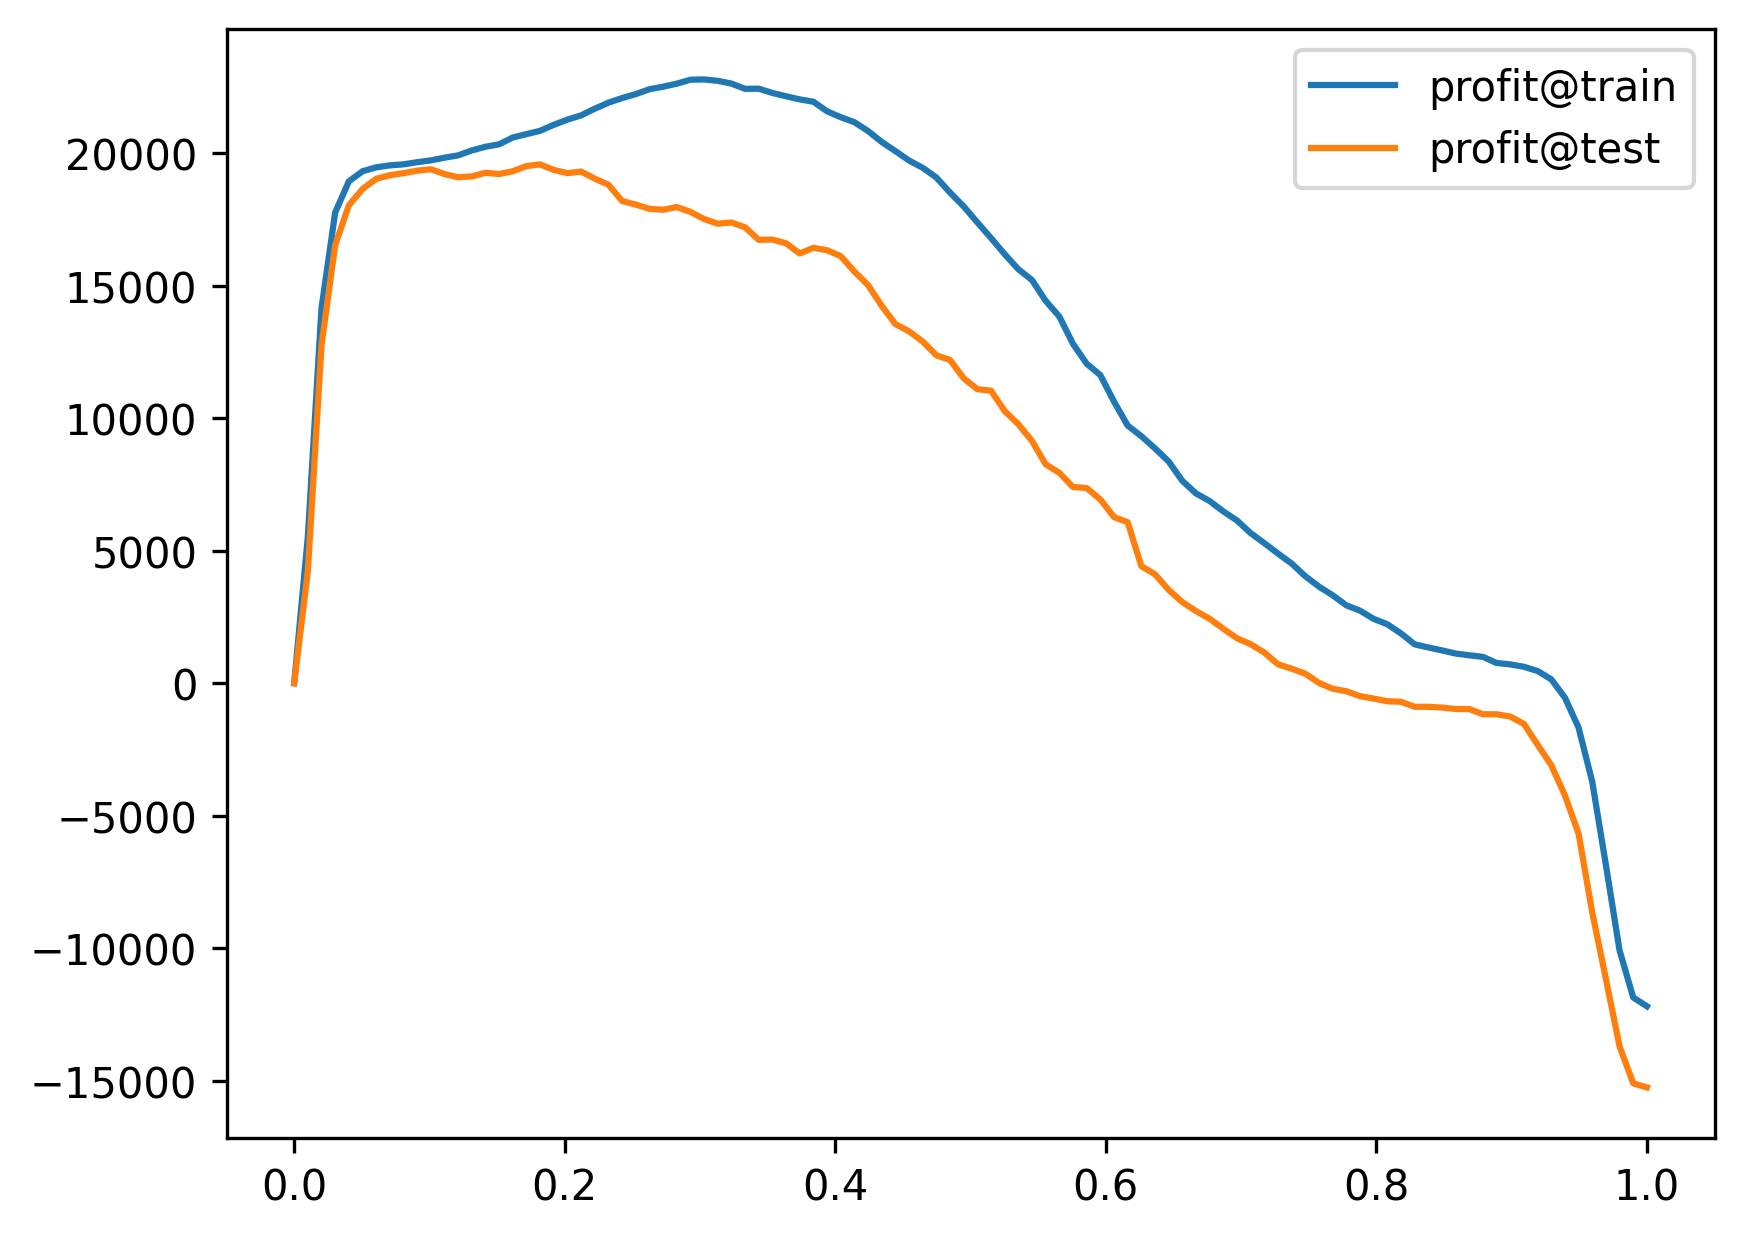

In [193]:
plt.plot(stats_t["t"], stats_t["profit@train"], label="profit@train")
plt.plot(stats_t["t"], stats_t["profit@test"], label="profit@test")
plt.legend()

In [194]:
stats_t.sort_values(by=["profit@test"], ascending=False)

,t,profit@train,profit@test
18,0.181818,20855.447531,19585.257146
17,0.171717,20727.701050,19522.161488
10,0.101010,19737.783563,19402.815830
19,0.191919,21079.794291,19376.893001
9,0.090909,19668.281654,19347.845172
...,...,...,...
95,0.959596,-3720.234825,-8656.195906
96,0.969697,-6862.638789,-11165.446248
97,0.979798,-10086.743906,-13708.778171
98,0.989899,-11864.073030,-15105.821932


In [204]:
y_pred_train = (clf.predict_proba(X_train)[:, 1] > 0.3).astype(int)
y_pred_test = (clf.predict_proba(X_test)[:, 1] > 0.3).astype(int)
print("Бизнес-метрика на трейне", our_profit(df_train["сумма"], y_pred_train, y_train))
print("Бизнес-метрика на тесте", our_profit(df_test["сумма"], y_pred_test, y_test))
print("Точность на трейне:", clf.score(X_train, y_train))
print("Точность на тесте:", clf.score(X_test, y_test))

Бизнес-метрика на трейне 22798.870022082265
Бизнес-метрика на тесте 17699.32108605728
Точность на трейне: 0.943125
Точность на тесте: 0.895625


In [198]:
fis = pd.Series(dict(zip(X_train.columns, clf.feature_importances_))).sort_values(ascending=False).head(10)
fis

сбор_mean_encoded      0.506774
тип_кредита            0.220859
стоимость_имущества    0.080323
сумма                  0.043848
символов_в_речи        0.030712
кредитный_рейтинг      0.020234
цель                   0.019487
возраст                0.017458
один_платеж            0.015121
амортизация            0.010934
dtype: float64

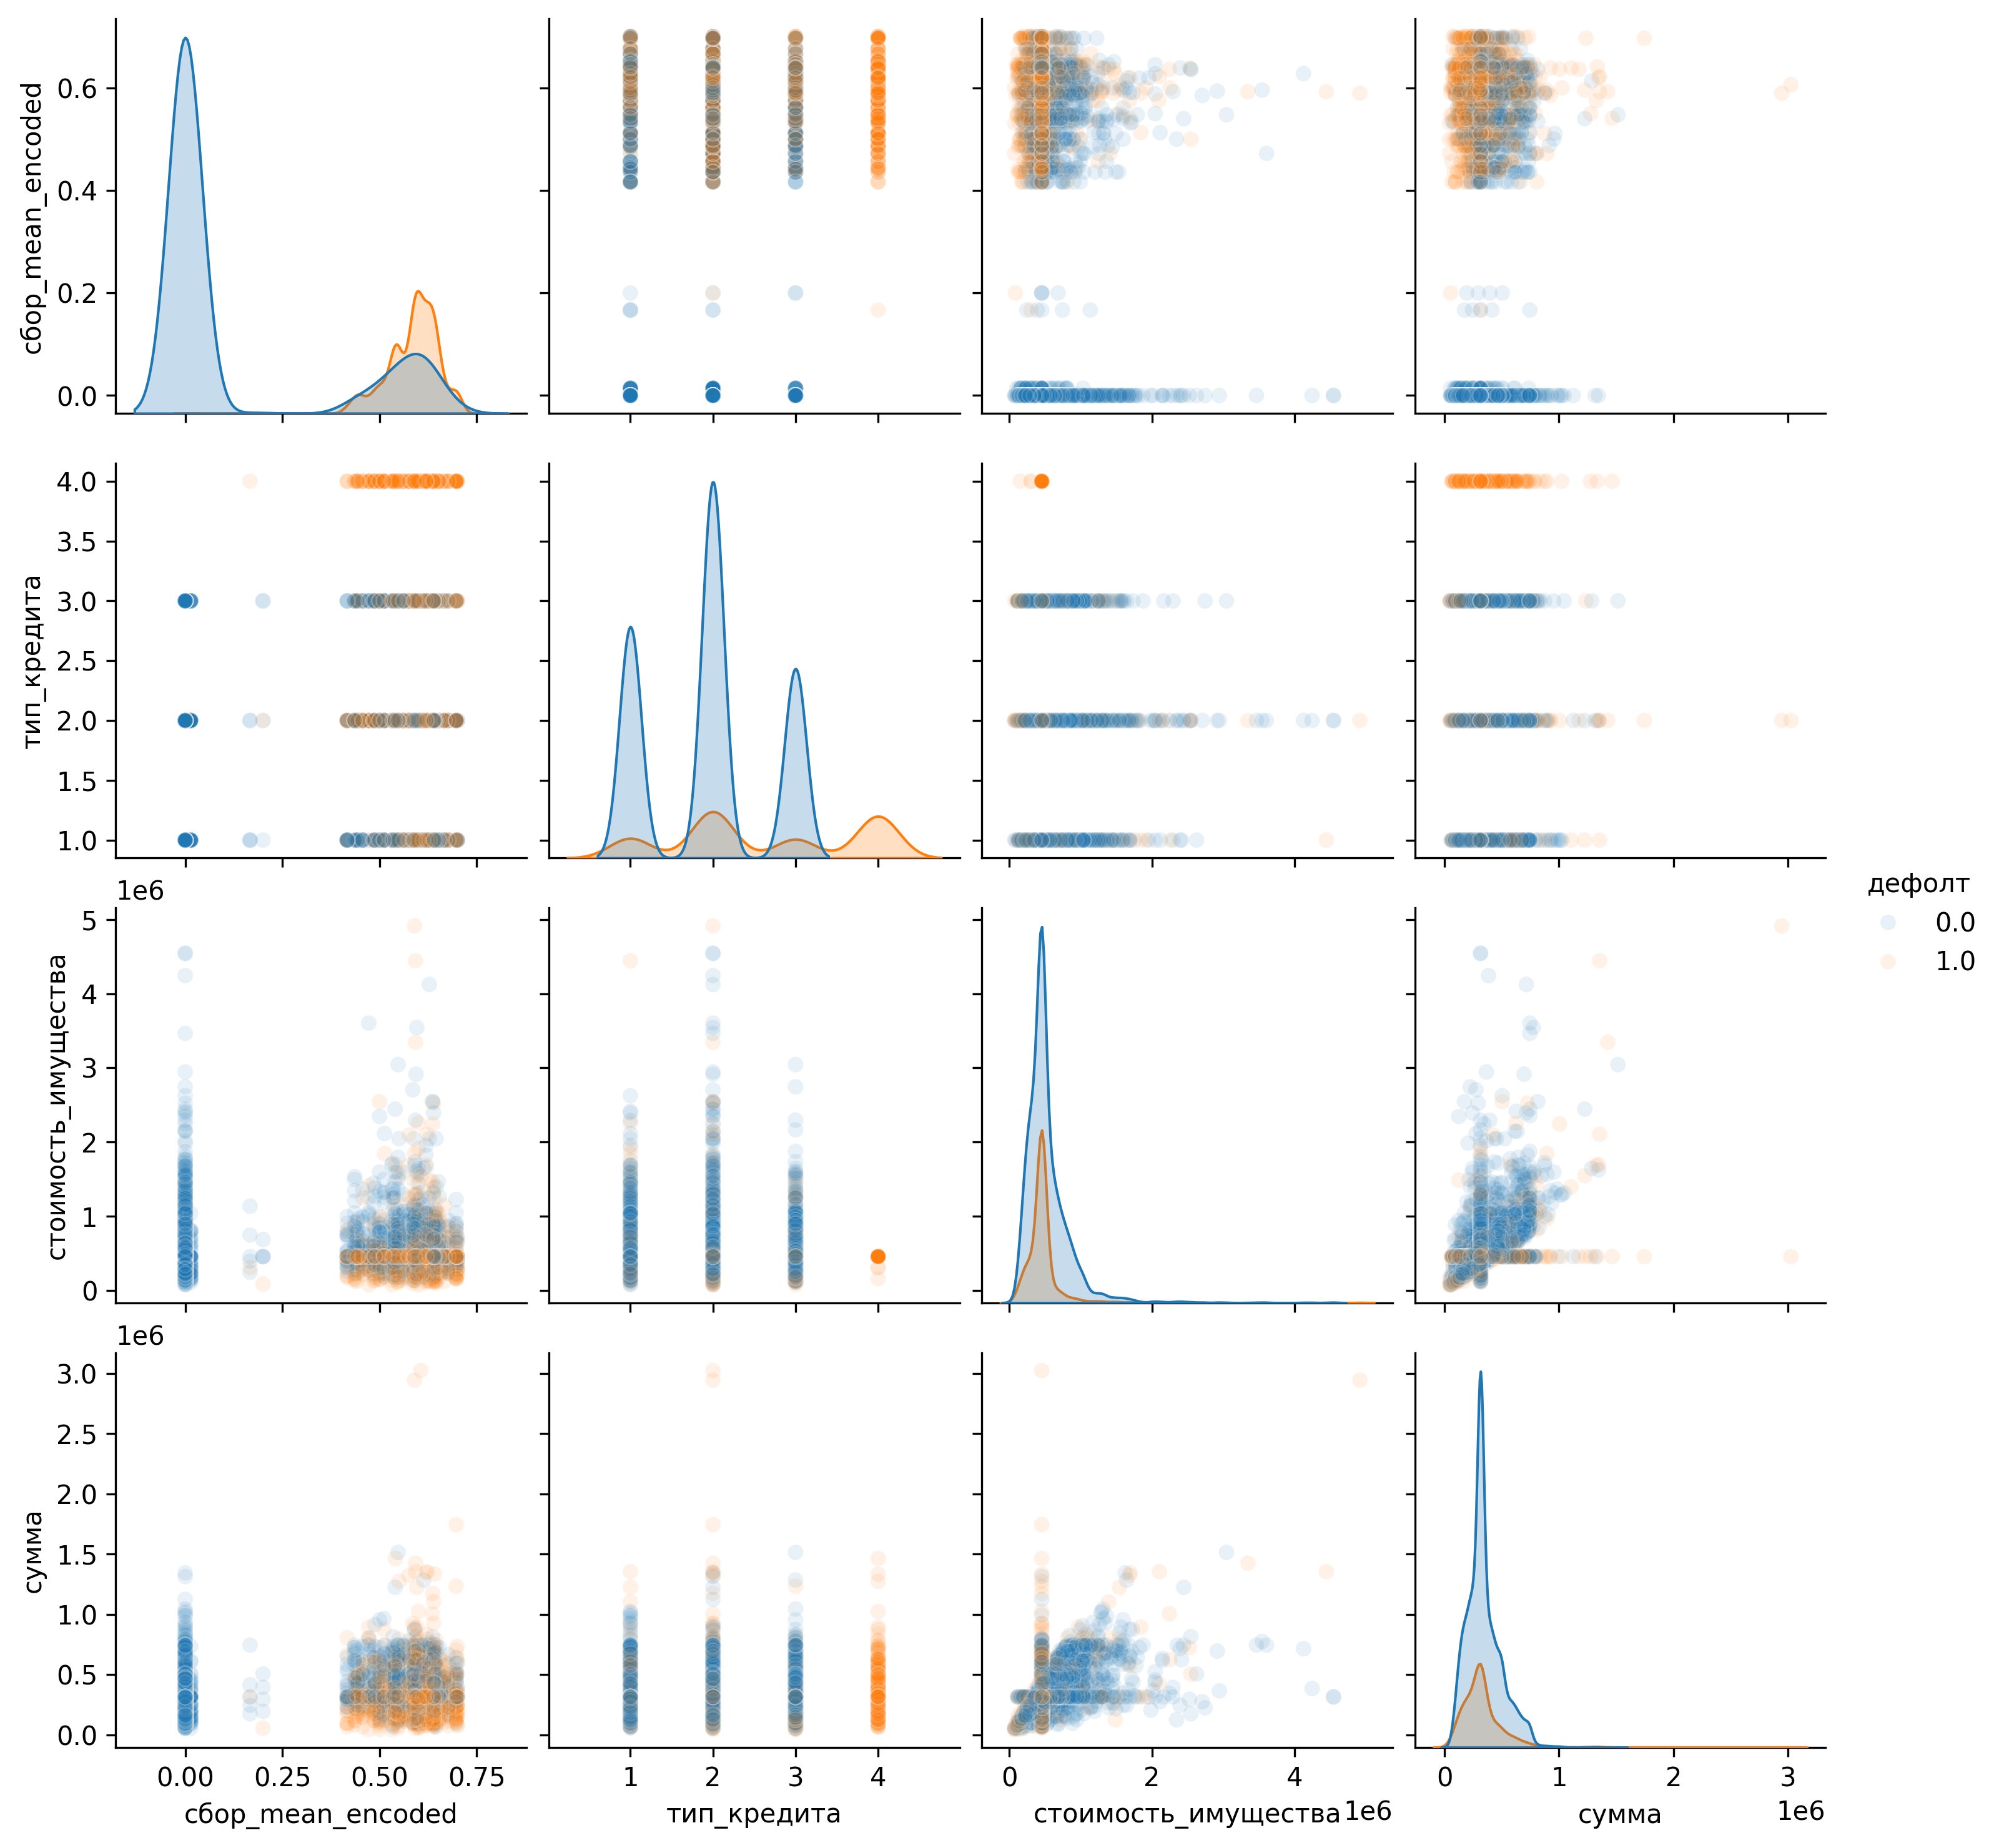

In [203]:
sns.pairplot(data=df_train, vars=fis.index[:4], hue="дефолт",  plot_kws={'alpha':0.1})

In [ ]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

y_pred_train = clf.predict_(X_train)
y_pred_test = clf.predict(X_test)

In [156]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print("Бизнес-метрика на трейне", our_profit(df_train["сумма"], y_pred_train, y_train))
print("Бизнес-метрика на тесте", our_profit(df_test["сумма"], y_pred_test, y_test))
print("Точность на трейне:", clf.score(X_train, y_train))
print("Точность на тесте:", clf.score(X_test, y_test))

Бизнес-метрика на трейне 94674361.3162497
Бизнес-метрика на тесте 20904857.286229625
Точность на трейне: 0.8834375
Точность на тесте: 0.87625


In [ ]:
# если дефолт не было, зарабатываем 10%,
# если был: теряем 50% от суммы
# 

In [123]:
X_train

,лимит_нарушен,пол,тип,цель,кредитоспособность,другие_кредиты,бизнес,сумма,срок,амортизация,только_процент,один_платеж,стоимость_имущества,тип_кредита,кредитный_рейтинг,возраст,прямой_залог,сбор_mean_encoded,проживание_mean_encoded,символов_в_речи
0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,304765.264968,365.885949,0.0,0.0,0.0,3.744881e+05,2.0,799.508335,3.0,1.0,0.000000,0.231492,232.0
1,1.0,0.0,1.0,3.0,1.0,0.0,0.0,314765.264968,365.885949,0.0,0.0,0.0,9.444881e+05,3.0,672.508335,1.0,1.0,0.619048,0.231492,244.0
2,0.0,0.0,3.0,0.0,1.0,0.0,0.0,744765.264968,245.885949,0.0,0.0,0.0,1.294488e+06,2.0,708.508335,3.0,1.0,0.000000,0.231492,278.0
3,0.0,1.0,2.0,3.0,1.0,0.0,0.0,284765.264968,365.885949,0.0,0.0,0.0,4.544881e+05,4.0,708.508335,0.0,1.0,0.641026,0.231492,266.0
4,0.0,0.0,2.0,3.0,1.0,0.0,1.0,204765.264968,365.885949,1.0,0.0,0.0,4.544881e+05,4.0,713.508335,5.0,1.0,0.547619,0.231492,214.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6395,0.0,0.0,3.0,1.0,1.0,0.0,0.0,314765.264968,365.885949,0.0,0.0,0.0,9.444881e+05,3.0,708.508335,5.0,1.0,0.000000,0.231492,252.0
6396,0.0,0.0,3.0,0.0,1.0,0.0,0.0,424765.264968,329.885949,0.0,0.0,0.0,4.544881e+05,1.0,824.508335,5.0,1.0,0.641026,0.231492,293.0
6397,0.0,0.0,2.0,1.0,1.0,0.0,1.0,234765.264968,365.885949,1.0,0.0,0.0,2.844881e+05,1.0,862.508335,3.0,1.0,0.000000,0.231492,230.0
6398,0.0,0.0,3.0,3.0,1.0,0.0,0.0,164765.264968,365.885949,1.0,0.0,0.0,2.244881e+05,2.0,708.508335,2.0,1.0,0.000000,0.231492,248.0
